In [1]:
import pandas as pd
from pandas import DataFrame
from pandas import concat
import numpy as np
from numpy import concatenate
import matplotlib.pyplot as plt
import math
from math import sqrt
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import seaborn as sns
import shap
import tensorflow as tf
tf.compat.v1.disable_v2_behavior()
#tf.compat.v1.keras.backend.get_session

Instructions for updating:
non-resource variables are not supported in the long term


Read data in and clean

In [2]:
# Import csv file prices_prod
source_df = pd.read_csv('./Resources/prices_clim_mod.csv', parse_dates=['date'], index_col= 'date' )
source_df.reset_index(inplace=True)
source_df.sort_index(inplace=True)
source_df.head()
source_df.dropna()

,date,avg_price,year_month,geography,type,prices_total_volume,units_4046,units_4225,units_4770,total_bags,...,cdd,sp01,sp02,sp03,sp06,sp09,sp12,sp24,tmin,tmax
0,2017-01-08,0.78,1/1/2017,Dallas/FtWorth,conventional,1247488.60,556814.80,343124.23,2551.41,344998.16,...,0,1.78,1.59,1.43,1.77,1.69,1.29,0.7,34.0,50.3
1,2017-01-08,1.74,1/1/2017,Atlanta,organic,8244.17,1456.00,5316.57,0.00,1471.60,...,0,1.78,1.59,1.43,1.77,1.69,1.29,0.7,34.0,50.3
2,2017-01-22,1.51,1/1/2017,Chicago,organic,47561.03,52.69,43587.09,0.00,3921.25,...,0,1.78,1.59,1.43,1.77,1.69,1.29,0.7,34.0,50.3
3,2017-01-02,1.79,1/1/2017,GrandRapids,organic,1095.77,84.21,738.23,0.00,273.33,...,0,1.78,1.59,1.43,1.77,1.69,1.29,0.7,34.0,50.3
4,2017-01-22,0.74,1/1/2017,SouthCentral,conventional,6207638.50,4020198.09,957479.68,23685.51,1206275.22,...,0,1.78,1.59,1.43,1.77,1.69,1.29,0.7,34.0,50.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20405,2020-09-06,1.09,9/1/2020,NewYork,conventional,2454855.84,72130.55,1564749.80,2680.49,815295.00,...,268,-1.68,-1.67,-1.95,0.03,-1.25,-1.12,0.0,59.4,89.0
20406,2020-09-06,1.00,9/1/2020,Baltimore/Washington,conventional,1157352.09,114543.47,463911.16,4732.33,574165.13,...,268,-1.68,-1.67,-1.95,0.03,-1.25,-1.12,0.0,59.4,89.0
20407,2020-09-06,1.14,9/1/2020,NorthernNewEngland,conventional,599275.15,17186.93,432244.14,78.56,149765.52,...,268,-1.68,-1.67,-1.95,0.03,-1.25,-1.12,0.0,59.4,89.0
20408,2020-09-06,0.76,9/1/2020,Indianapolis,conventional,317028.79,103261.66,21501.55,3538.51,188727.07,...,268,-1.68,-1.67,-1.95,0.03,-1.25,-1.12,0.0,59.4,89.0


In [3]:
# Drop the non-beneficial columns, 'status' and 'prod'.
prices_df = source_df.drop(['year_month', 'prices_total_volume','total_bags'],axis=1)
prices_df

,date,avg_price,geography,type,units_4046,units_4225,units_4770,s_bags,l_bags,xl_bags,...,cdd,sp01,sp02,sp03,sp06,sp09,sp12,sp24,tmin,tmax
0,2017-01-08,0.78,Dallas/FtWorth,conventional,556814.80,343124.23,2551.41,341681.22,3247.62,69.32,...,0,1.78,1.59,1.43,1.77,1.69,1.29,0.7,34.0,50.3
1,2017-01-08,1.74,Atlanta,organic,1456.00,5316.57,0.00,0.00,1471.60,0.00,...,0,1.78,1.59,1.43,1.77,1.69,1.29,0.7,34.0,50.3
2,2017-01-22,1.51,Chicago,organic,52.69,43587.09,0.00,3921.25,0.00,0.00,...,0,1.78,1.59,1.43,1.77,1.69,1.29,0.7,34.0,50.3
3,2017-01-02,1.79,GrandRapids,organic,84.21,738.23,0.00,263.33,10.00,0.00,...,0,1.78,1.59,1.43,1.77,1.69,1.29,0.7,34.0,50.3
4,2017-01-22,0.74,SouthCentral,conventional,4020198.09,957479.68,23685.51,1066264.87,128528.14,11482.21,...,0,1.78,1.59,1.43,1.77,1.69,1.29,0.7,34.0,50.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20405,2020-09-06,1.09,NewYork,conventional,72130.55,1564749.80,2680.49,583789.55,228511.87,2993.58,...,268,-1.68,-1.67,-1.95,0.03,-1.25,-1.12,0.0,59.4,89.0
20406,2020-09-06,1.00,Baltimore/Washington,conventional,114543.47,463911.16,4732.33,245117.49,322831.54,6216.10,...,268,-1.68,-1.67,-1.95,0.03,-1.25,-1.12,0.0,59.4,89.0
20407,2020-09-06,1.14,NorthernNewEngland,conventional,17186.93,432244.14,78.56,85134.26,63061.88,1569.38,...,268,-1.68,-1.67,-1.95,0.03,-1.25,-1.12,0.0,59.4,89.0
20408,2020-09-06,0.76,Indianapolis,conventional,103261.66,21501.55,3538.51,177417.16,9669.39,1640.52,...,268,-1.68,-1.67,-1.95,0.03,-1.25,-1.12,0.0,59.4,89.0


In [4]:
# Drop rows that are totals for included sub areas and thus duplicates
prices_df = prices_df.drop(prices_df[(source_df.geography == 'California') | 
                                (prices_df.geography == 'Southeast') |
                                   (source_df.geography == 'TotalUS') |
                                   (source_df.geography == 'Midsouth') |
                                   (source_df.geography == 'Northeast') |
                                   (source_df.geography == 'Southeast') |
                                   (source_df.geography == 'West') ].index)
prices_df

,date,avg_price,geography,type,units_4046,units_4225,units_4770,s_bags,l_bags,xl_bags,...,cdd,sp01,sp02,sp03,sp06,sp09,sp12,sp24,tmin,tmax
0,2017-01-08,0.78,Dallas/FtWorth,conventional,556814.80,343124.23,2551.41,341681.22,3247.62,69.32,...,0,1.78,1.59,1.43,1.77,1.69,1.29,0.7,34.0,50.3
1,2017-01-08,1.74,Atlanta,organic,1456.00,5316.57,0.00,0.00,1471.60,0.00,...,0,1.78,1.59,1.43,1.77,1.69,1.29,0.7,34.0,50.3
2,2017-01-22,1.51,Chicago,organic,52.69,43587.09,0.00,3921.25,0.00,0.00,...,0,1.78,1.59,1.43,1.77,1.69,1.29,0.7,34.0,50.3
3,2017-01-02,1.79,GrandRapids,organic,84.21,738.23,0.00,263.33,10.00,0.00,...,0,1.78,1.59,1.43,1.77,1.69,1.29,0.7,34.0,50.3
4,2017-01-22,0.74,SouthCentral,conventional,4020198.09,957479.68,23685.51,1066264.87,128528.14,11482.21,...,0,1.78,1.59,1.43,1.77,1.69,1.29,0.7,34.0,50.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20404,2020-09-06,1.65,Charlotte,organic,87.19,3662.19,40.24,9875.50,970.84,0.00,...,268,-1.68,-1.67,-1.95,0.03,-1.25,-1.12,0.0,59.4,89.0
20405,2020-09-06,1.09,NewYork,conventional,72130.55,1564749.80,2680.49,583789.55,228511.87,2993.58,...,268,-1.68,-1.67,-1.95,0.03,-1.25,-1.12,0.0,59.4,89.0
20406,2020-09-06,1.00,Baltimore/Washington,conventional,114543.47,463911.16,4732.33,245117.49,322831.54,6216.10,...,268,-1.68,-1.67,-1.95,0.03,-1.25,-1.12,0.0,59.4,89.0
20407,2020-09-06,1.14,NorthernNewEngland,conventional,17186.93,432244.14,78.56,85134.26,63061.88,1569.38,...,268,-1.68,-1.67,-1.95,0.03,-1.25,-1.12,0.0,59.4,89.0


In [5]:
# Correct the type catagory
prices_df.loc[prices_df['type'] == 'conventional ', 'type'] = 'conventional'
prices_df.groupby('type').size()

type
conventional    9072
organic         9070
dtype: int64

In [6]:
lstmconv_df = prices_df.loc[prices_df['type'] == 'conventional'].copy()
lstmconv_df.drop(['type'],axis=1, inplace=True)
lstmconv_df

,date,avg_price,geography,units_4046,units_4225,units_4770,s_bags,l_bags,xl_bags,pcp,...,cdd,sp01,sp02,sp03,sp06,sp09,sp12,sp24,tmin,tmax
0,2017-01-08,0.78,Dallas/FtWorth,556814.80,343124.23,2551.41,341681.22,3247.62,69.32,9.92,...,0,1.78,1.59,1.43,1.77,1.69,1.29,0.7,34.0,50.3
4,2017-01-22,0.74,SouthCentral,4020198.09,957479.68,23685.51,1066264.87,128528.14,11482.21,9.92,...,0,1.78,1.59,1.43,1.77,1.69,1.29,0.7,34.0,50.3
5,2017-01-08,1.40,Miami/FtLauderdale,209904.22,121128.25,293.18,85738.78,105206.85,6.94,9.92,...,0,1.78,1.59,1.43,1.77,1.69,1.29,0.7,34.0,50.3
9,2017-01-22,1.04,Roanoke,48905.14,46802.42,142.99,66764.36,883.94,0.00,9.92,...,0,1.78,1.59,1.43,1.77,1.69,1.29,0.7,34.0,50.3
10,2017-01-29,1.00,StLouis,80253.19,15081.96,159.98,63464.66,33402.39,0.00,9.92,...,0,1.78,1.59,1.43,1.77,1.69,1.29,0.7,34.0,50.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20403,2020-09-06,1.30,Albany,8926.79,104185.45,118.00,17394.83,8510.43,577.36,0.04,...,268,-1.68,-1.67,-1.95,0.03,-1.25,-1.12,0.0,59.4,89.0
20405,2020-09-06,1.09,NewYork,72130.55,1564749.80,2680.49,583789.55,228511.87,2993.58,0.04,...,268,-1.68,-1.67,-1.95,0.03,-1.25,-1.12,0.0,59.4,89.0
20406,2020-09-06,1.00,Baltimore/Washington,114543.47,463911.16,4732.33,245117.49,322831.54,6216.10,0.04,...,268,-1.68,-1.67,-1.95,0.03,-1.25,-1.12,0.0,59.4,89.0
20407,2020-09-06,1.14,NorthernNewEngland,17186.93,432244.14,78.56,85134.26,63061.88,1569.38,0.04,...,268,-1.68,-1.67,-1.95,0.03,-1.25,-1.12,0.0,59.4,89.0


In [7]:
lstmorg_df = prices_df.loc[prices_df['type'] == 'organic'].copy()
lstmorg_df.drop(['type'],axis=1, inplace=True)
lstmorg_df

,date,avg_price,geography,units_4046,units_4225,units_4770,s_bags,l_bags,xl_bags,pcp,...,cdd,sp01,sp02,sp03,sp06,sp09,sp12,sp24,tmin,tmax
1,2017-01-08,1.74,Atlanta,1456.00,5316.57,0.00,0.00,1471.60,0.0,9.92,...,0,1.78,1.59,1.43,1.77,1.69,1.29,0.7,34.0,50.3
2,2017-01-22,1.51,Chicago,52.69,43587.09,0.00,3921.25,0.00,0.0,9.92,...,0,1.78,1.59,1.43,1.77,1.69,1.29,0.7,34.0,50.3
3,2017-01-02,1.79,GrandRapids,84.21,738.23,0.00,263.33,10.00,0.0,9.92,...,0,1.78,1.59,1.43,1.77,1.69,1.29,0.7,34.0,50.3
7,2017-01-02,1.46,StLouis,1662.86,413.93,0.00,716.11,3057.90,0.0,9.92,...,0,1.78,1.59,1.43,1.77,1.69,1.29,0.7,34.0,50.3
8,2017-01-02,1.40,Houston,7550.89,58.71,0.00,2499.86,0.00,0.0,9.92,...,0,1.78,1.59,1.43,1.77,1.69,1.29,0.7,34.0,50.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20398,2020-09-06,1.93,Boston,144.34,2215.12,0.00,32786.65,1029.05,0.0,0.04,...,268,-1.68,-1.67,-1.95,0.03,-1.25,-1.12,0.0,59.4,89.0
20399,2020-09-06,1.76,Boise,0.00,680.04,0.00,1696.67,4806.52,0.0,0.04,...,268,-1.68,-1.67,-1.95,0.03,-1.25,-1.12,0.0,59.4,89.0
20401,2020-09-06,1.63,Tampa,115.22,0.00,0.00,3427.70,1438.89,0.0,0.04,...,268,-1.68,-1.67,-1.95,0.03,-1.25,-1.12,0.0,59.4,89.0
20402,2020-09-06,1.69,Baltimore/Washington,662.61,4353.40,6.56,30992.62,5476.07,0.0,0.04,...,268,-1.68,-1.67,-1.95,0.03,-1.25,-1.12,0.0,59.4,89.0


In [8]:
# Compare prices to price information
#g = sns.PairGrid(source_df[['avg_price', 'units_4046', 'units_4225',
#                           'units_4770', 's_bags', 'l_bags', 'xl_bags']])
#g.map(sns.scatterplot)

In [9]:
# Compare prices to climate information
#g = sns.PairGrid(source_df[['avg_price', 'pcp', 'tavg', 'pdsi',
#       'phdi', 'zndx', 'pmdi', 'cdd', 'sp01', 'sp02', 'sp03', 'sp06', 'sp09',
#       'sp12', 'sp24', 'tmin', 'tmax', ]])
#g.map(sns.scatterplot)

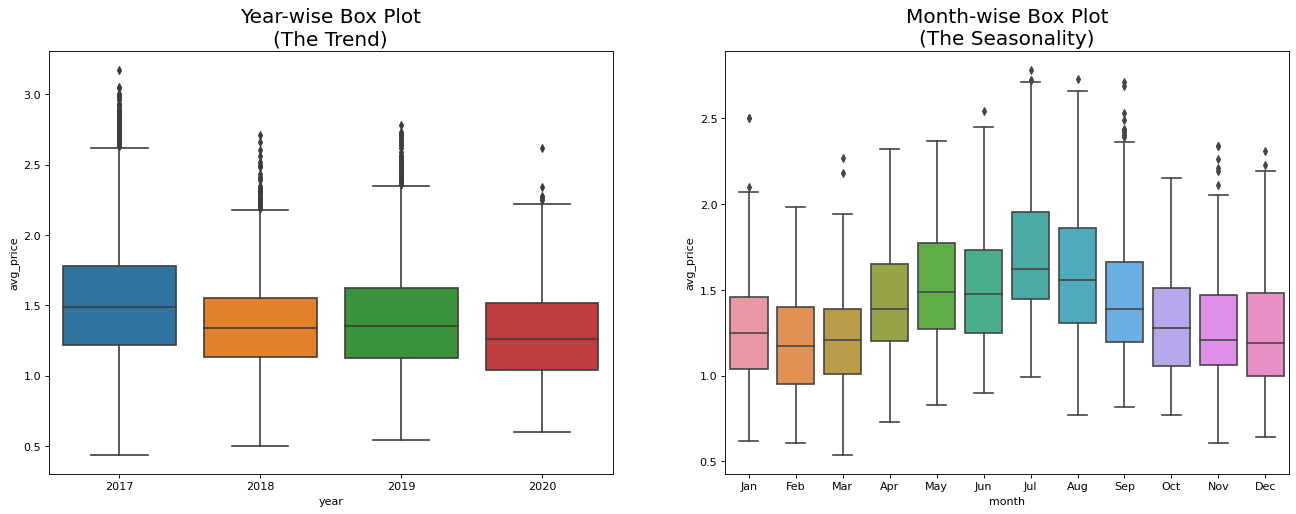

In [10]:
# Prepare data
prices_df['year'] = [d.year for d in prices_df.date]
prices_df['month'] = [d.strftime('%b') for d in prices_df.date]
years = prices_df['year'].unique()

# Draw Plot
fig, axes = plt.subplots(1, 2, figsize=(20,7), dpi= 80)
sns.boxplot(x='year', y='avg_price', data=prices_df, ax=axes[0])
sns.boxplot(x='month', y='avg_price', data=prices_df.loc[~prices_df.year.isin([2017,2018, 2020]), :])            
# Set Title
axes[0].set_title('Year-wise Box Plot\n(The Trend)', fontsize=18); 
axes[1].set_title('Month-wise Box Plot\n(The Seasonality)', fontsize=18)
plt.show()

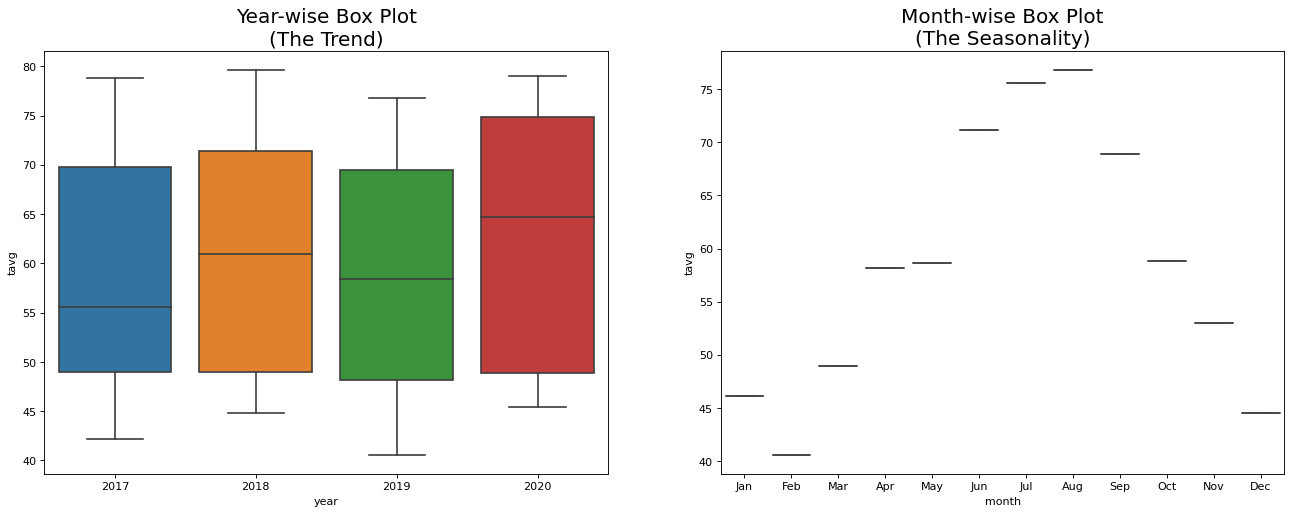

In [11]:
# Draw Plot
fig, axes = plt.subplots(1, 2, figsize=(20,7), dpi= 80)
sns.boxplot(x='year', y='tavg', data=prices_df, ax=axes[0])
sns.boxplot(x='month', y='tavg', data=prices_df.loc[~prices_df.year.isin([2017, 2018, 2020]), :])            
# Set Title
axes[0].set_title('Year-wise Box Plot\n(The Trend)', fontsize=18); 
axes[1].set_title('Month-wise Box Plot\n(The Seasonality)', fontsize=18)
plt.show()

In [12]:
lstmconv_df.reset_index(drop=True, inplace=True)
prices_df.reset_index(drop=True, inplace=True)
lstmorg_df.reset_index(drop=True, inplace=True)

LSTM Data Preparation

In [13]:
lstmconv_df.to_csv('lstm_cleaned_conv_prices_clim.csv')
lstmorg_df.to_csv('lstm_cleaned_org_prices_clim.csv')
prices_df.to_csv('lstm_cleaned_all_prices_clim.csv')

Data pipeline including lags

In [14]:
# read in data
dataset = pd.read_csv('lstm_cleaned_conv_prices_clim.csv', header=0, index_col=0)
dataset

,date,avg_price,geography,units_4046,units_4225,units_4770,s_bags,l_bags,xl_bags,pcp,...,cdd,sp01,sp02,sp03,sp06,sp09,sp12,sp24,tmin,tmax
0,2017-01-08,0.78,Dallas/FtWorth,556814.80,343124.23,2551.41,341681.22,3247.62,69.32,9.92,...,0,1.78,1.59,1.43,1.77,1.69,1.29,0.7,34.0,50.3
1,2017-01-22,0.74,SouthCentral,4020198.09,957479.68,23685.51,1066264.87,128528.14,11482.21,9.92,...,0,1.78,1.59,1.43,1.77,1.69,1.29,0.7,34.0,50.3
2,2017-01-08,1.40,Miami/FtLauderdale,209904.22,121128.25,293.18,85738.78,105206.85,6.94,9.92,...,0,1.78,1.59,1.43,1.77,1.69,1.29,0.7,34.0,50.3
3,2017-01-22,1.04,Roanoke,48905.14,46802.42,142.99,66764.36,883.94,0.00,9.92,...,0,1.78,1.59,1.43,1.77,1.69,1.29,0.7,34.0,50.3
4,2017-01-29,1.00,StLouis,80253.19,15081.96,159.98,63464.66,33402.39,0.00,9.92,...,0,1.78,1.59,1.43,1.77,1.69,1.29,0.7,34.0,50.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9067,2020-09-06,1.30,Albany,8926.79,104185.45,118.00,17394.83,8510.43,577.36,0.04,...,268,-1.68,-1.67,-1.95,0.03,-1.25,-1.12,0.0,59.4,89.0
9068,2020-09-06,1.09,NewYork,72130.55,1564749.80,2680.49,583789.55,228511.87,2993.58,0.04,...,268,-1.68,-1.67,-1.95,0.03,-1.25,-1.12,0.0,59.4,89.0
9069,2020-09-06,1.00,Baltimore/Washington,114543.47,463911.16,4732.33,245117.49,322831.54,6216.10,0.04,...,268,-1.68,-1.67,-1.95,0.03,-1.25,-1.12,0.0,59.4,89.0
9070,2020-09-06,1.14,NorthernNewEngland,17186.93,432244.14,78.56,85134.26,63061.88,1569.38,0.04,...,268,-1.68,-1.67,-1.95,0.03,-1.25,-1.12,0.0,59.4,89.0


In [15]:
def series_to_supervised(data, n_in=2, n_out=1, dropnan=False):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

# read in data
dataset = pd.read_csv('lstm_cleaned_conv_prices_clim.csv', header=0, index_col=0)

# Generate our categorical variable lists
cat = dataset.dtypes[dataset.dtypes == "object"].index.tolist()


# Create a OneHotEncoder instance
enc = OneHotEncoder(sparse=False)

# Fit and transform the OneHotEncoder using the categorical variable list
encode_df = pd.DataFrame(enc.fit_transform(dataset[cat]))

# Add the encoded variable names to the dataframe
encode_df.columns = enc.get_feature_names(cat)

# Merge one-hot encoded features and drop the originals
dataset = dataset.merge(encode_df,left_index=True, right_index=True)
dataset = dataset.drop(cat,1)

#Ensure values are float
dataset = dataset.astype('float')


# Normalize the dataset
scaler = MinMaxScaler(feature_range=(0,1))
scaled= scaler.fit_transform(dataset)

# Reframe as supervised learning
reframed = series_to_supervised(scaled, 1, 1)


# drop columns we don't want to predict
reframed.drop(reframed.iloc[:, 261:,], axis=1, inplace=True)
reframed.drop(reframed.index[0], inplace=True)
reframed.shape

(9071, 261)

In [16]:
dataset

,avg_price,units_4046,units_4225,units_4770,s_bags,l_bags,xl_bags,pcp,tavg,pdsi,...,geography_SanDiego,geography_SanFrancisco,geography_Seattle,geography_SouthCarolina,geography_SouthCentral,geography_Spokane,geography_StLouis,geography_Syracuse,geography_Tampa,geography_WestTex/NewMexico
0,0.78,556814.80,343124.23,2551.41,341681.22,3247.62,69.32,9.92,42.2,3.61,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.74,4020198.09,957479.68,23685.51,1066264.87,128528.14,11482.21,9.92,42.2,3.61,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,1.40,209904.22,121128.25,293.18,85738.78,105206.85,6.94,9.92,42.2,3.61,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.04,48905.14,46802.42,142.99,66764.36,883.94,0.00,9.92,42.2,3.61,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.00,80253.19,15081.96,159.98,63464.66,33402.39,0.00,9.92,42.2,3.61,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9067,1.30,8926.79,104185.45,118.00,17394.83,8510.43,577.36,0.04,74.2,-2.27,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9068,1.09,72130.55,1564749.80,2680.49,583789.55,228511.87,2993.58,0.04,74.2,-2.27,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9069,1.00,114543.47,463911.16,4732.33,245117.49,322831.54,6216.10,0.04,74.2,-2.27,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9070,1.14,17186.93,432244.14,78.56,85134.26,63061.88,1569.38,0.04,74.2,-2.27,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [17]:
reframed

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var8(t-1),var9(t-1),var10(t-1),...,var252(t-1),var253(t-1),var254(t-1),var255(t-1),var256(t-1),var257(t-1),var258(t-1),var259(t-1),var260(t-1),var1(t)
1,0.181818,0.060751,0.040896,0.003210,0.061516,0.001520,0.000140,1.0,0.041026,0.870932,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.159091
2,0.159091,0.439165,0.114445,0.029803,0.193009,0.060138,0.023178,1.0,0.041026,0.870932,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.534091
3,0.534091,0.022847,0.014319,0.000369,0.015069,0.049226,0.000014,1.0,0.041026,0.870932,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.329545
4,0.329545,0.005256,0.005421,0.000180,0.011625,0.000414,0.000000,1.0,0.041026,0.870932,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.306818
5,0.306818,0.008682,0.001624,0.000201,0.011026,0.015629,0.000000,1.0,0.041026,0.870932,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.363636
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9067,0.210227,0.032162,0.002126,0.000189,0.061296,0.013486,0.026358,0.0,0.861538,0.210999,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.477273
9068,0.477273,0.000888,0.012291,0.000148,0.002666,0.003982,0.001165,0.0,0.861538,0.210999,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.357955
9069,0.357955,0.007794,0.187146,0.003373,0.105452,0.106919,0.006043,0.0,0.861538,0.210999,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.306818
9070,0.306818,0.012428,0.055357,0.005955,0.043992,0.151051,0.012548,0.0,0.861538,0.210999,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.386364


In [18]:
# split into train and test sets
value = reframed
n_train = 7343 # 2017 through 2019
n_features = 261
train = value[:n_train].values
test = value[n_train:].values
train_X, train_y = train[:, :-1], train[:, -1]
train_X_no_timesteps = train[:, :-1]
test_X, test_y = test[:, :-1], test[:, -1]

# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)
print(train_X_no_timesteps.shape)

(7343, 1, 260) (7343,) (1728, 1, 260) (1728,)
(7343, 260)


## Instanciate and fit LSTM model with lags

Train on 7343 samples, validate on 1728 samples
Epoch 1/50
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
7343/7343 - 0s - loss: 0.1252 - val_loss: 0.1703
Epoch 2/50
7343/7343 - 0s - loss: 0.1446 - val_loss: 0.1248
Epoch 3/50
7343/7343 - 0s - loss: 0.1156 - val_loss: 0.1221
Epoch 4/50
7343/7343 - 0s - loss: 0.1144 - val_loss: 0.1052
Epoch 5/50
7343/7343 - 0s - loss: 0.1094 - val_loss: 0.1255
Epoch 6/50
7343/7343 - 0s - loss: 0.1149 - val_loss: 0.1069
Epoch 7/50
7343/7343 - 0s - loss: 0.1087 - val_loss: 0.1074
Epoch 8/50
7343/7343 - 0s - loss: 0.1091 - val_loss: 0.1092
Epoch 9/50
7343/7343 - 0s - loss: 0.1038 - val_loss: 0.1204
Epoch 10/50
7343/7343 - 0s - loss: 0.1058 - val_loss: 0.1125
Epoch 11/50
7343/7343 - 0s - loss: 0.1066 - val_loss: 0.1040
Epoch 12/50
7343/7343 - 0s - loss: 0.1098 - val_loss: 0.1134
Epoch 13/50
7343/7343 - 0s - loss: 0.1022 - val_loss: 0.1465
Epoch 14/50
7343/7343 - 0s - loss: 0.1019 - val_los

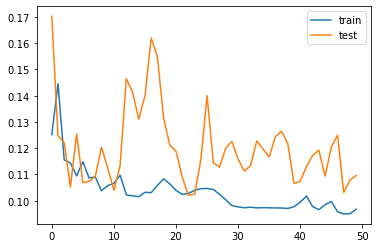

Test RMSE: 0.245


In [19]:
# design network
model = Sequential()
model.add(LSTM(150, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=50, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))

# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]

# invert scaling for actual
test_y = test_y.reshape((len(
    test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)


In [20]:
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)
print(inv_yhat.shape,inv_y.shape )

(7343, 1, 260) (7343,) (1728, 260) (1728, 1)
(1728,) (1728,)


In [21]:
# loss, accuracy = model.evaluate(train_X, train_y)

Multiple Lag Model

In [35]:

 
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg
 
# load dataset
dataset = pd.read_csv('lstm_cleaned_conv_prices_clim.csv', header=0, index_col=0)
values = dataset.values

# Generate our categorical variable lists
cat = dataset.dtypes[dataset.dtypes == "object"].index.tolist()


# Create a OneHotEncoder instance
enc = OneHotEncoder(sparse=False)

# Fit and transform the OneHotEncoder using the categorical variable list
encode_df = pd.DataFrame(enc.fit_transform(dataset[cat]))

# Add the encoded variable names to the dataframe
encode_df.columns = enc.get_feature_names(cat)

# Merge one-hot encoded features and drop the originals
dataset = dataset.merge(encode_df,left_index=True, right_index=True)
dataset = dataset.drop(cat,1)

#Ensure values are float
dataset = dataset.astype('float')

# Normalize the dataset
scaler = MinMaxScaler(feature_range=(0,1))
scaled= scaler.fit_transform(dataset)
len(dataset)

# specify the number of lag times
n_times = 1
n_features = 260
shape_adj = ((n_times - 1)*n_features) + 1

# frame as supervised learning
reframed = series_to_supervised(scaled, n_times, 1)
#print(reframed.shape)
 
# drop columns we don't want to predict
#reframed.drop(reframed.iloc[:, 168:,], axis=1, inplace=True)
#reframed.drop(reframed.index[0], inplace=True)
#print(reframed.shape)
  
# split into train and test sets
values = reframed.values
n_train =  7343 # 2018 through 2019 3216
train = values[:n_train, :]
test = values[n_train:, :]
#print(train.shape, test.shape)

#split into input and outputs
n_obs = n_times * n_features
train_X, train_y = train[:, :n_obs], train[:, -n_features]
test_X, test_y = test[:, :n_obs], test[:, -n_features]
#print(train_X.shape, train_y.shape,test_X.shape, test_y.shape)

# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], n_times, n_features))
test_X = test_X.reshape((test_X.shape[0], n_times, n_features))
#print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

# design network
model = Sequential()
model.add(LSTM(100, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')

# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()


ValueError: could not convert string to float: '2017-01-08'

In [23]:
labels = pd.DataFrame(reframed.columns)
labels.to_csv('lstm_labels.csv')
labels

,0
0,var1(t-1)
1,var2(t-1)
2,var3(t-1)
3,var4(t-1)
4,var5(t-1)
...,...
515,var256(t)
516,var257(t)
517,var258(t)
518,var259(t)


In [24]:
#explainer = shap.DeepExplainer(model, train_X)
#shap_values = explainer.shap_values(test_X)

# init the JS visualization code
#shap.initjs()
#shap.force_plot(explainer.expected_value[0], shap_values[0][0], test_X[0])

# shap.summary_plot(shap_values, test_X, plot_type="bar")


In [25]:
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], n_times*n_features))
#print(yhat.shape, test_X.shape)

In [26]:
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, shape_adj:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
print(inv_yhat.shape, yhat.shape, test_X[:, shape_adj:].shape)
print(inv_yhat)

(1728,) (1728, 1) (1728, 259)
[1.0162674  1.15864208 1.13093007 ... 1.27797635 1.23103299 1.23370144]


In [27]:
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, shape_adj:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 0.258


In [36]:
dataset[:7343]

,date,avg_price,geography,units_4046,units_4225,units_4770,s_bags,l_bags,xl_bags,pcp,...,geography_SanDiego,geography_SanFrancisco,geography_Seattle,geography_SouthCarolina,geography_SouthCentral,geography_Spokane,geography_StLouis,geography_Syracuse,geography_Tampa,geography_WestTex/NewMexico
0,2017-01-08,0.78,Dallas/FtWorth,556814.80,343124.23,2551.41,341681.22,3247.62,69.32,9.92,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2017-01-22,0.74,SouthCentral,4020198.09,957479.68,23685.51,1066264.87,128528.14,11482.21,9.92,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,2017-01-08,1.40,Miami/FtLauderdale,209904.22,121128.25,293.18,85738.78,105206.85,6.94,9.92,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2017-01-22,1.04,Roanoke,48905.14,46802.42,142.99,66764.36,883.94,0.00,9.92,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2017-01-29,1.00,StLouis,80253.19,15081.96,159.98,63464.66,33402.39,0.00,9.92,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7338,2019-12-22,1.40,NewYork,29973.38,810267.82,7636.31,451282.89,94264.73,4650.00,4.87,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7339,2019-12-22,0.88,Nashville,85573.42,6270.17,329.50,96998.28,20685.57,419.06,4.87,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7340,2019-12-22,1.10,Plains,628088.96,397913.73,9857.92,443689.47,150927.53,41094.82,4.87,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7341,2019-12-08,0.71,Phoenix/Tucson,498757.69,285332.65,2911.11,190400.27,318082.23,10.00,4.87,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [37]:
print(dataset[7344:])

            date  avg_price             geography  units_4046  units_4225  \
7344  2020-01-12       1.11               Spokane    17230.22    16545.99   
7345  2020-01-19       0.95             Charlotte   123956.22    51839.61   
7346  2020-01-19       1.14           GrandRapids     4615.63    84297.77   
7347  2020-01-26       1.06    Raleigh/Greensboro   150345.29    56879.49   
7348  2020-01-19       1.50          SanFrancisco   234478.13   297295.17   
...          ...        ...                   ...         ...         ...   
9067  2020-09-06       1.30                Albany     8926.79   104185.45   
9068  2020-09-06       1.09               NewYork    72130.55  1564749.80   
9069  2020-09-06       1.00  Baltimore/Washington   114543.47   463911.16   
9070  2020-09-06       1.14    NorthernNewEngland    17186.93   432244.14   
9071  2020-09-06       0.76          Indianapolis   103261.66    21501.55   

      units_4770     s_bags     l_bags   xl_bags   pcp  ...  \
7344      11

In [38]:
preds_df = dataset[7344:].copy() 
preds_df

,date,avg_price,geography,units_4046,units_4225,units_4770,s_bags,l_bags,xl_bags,pcp,...,geography_SanDiego,geography_SanFrancisco,geography_Seattle,geography_SouthCarolina,geography_SouthCentral,geography_Spokane,geography_StLouis,geography_Syracuse,geography_Tampa,geography_WestTex/NewMexico
7344,2020-01-12,1.11,Spokane,17230.22,16545.99,113.30,46850.74,41117.35,52.54,2.06,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
7345,2020-01-19,0.95,Charlotte,123956.22,51839.61,2271.02,182676.65,38332.54,273.33,2.06,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7346,2020-01-19,1.14,GrandRapids,4615.63,84297.77,104035.36,26839.12,5649.69,21755.03,2.06,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7347,2020-01-26,1.06,Raleigh/Greensboro,150345.29,56879.49,5119.19,132739.33,73234.60,6.67,2.06,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7348,2020-01-19,1.50,SanFrancisco,234478.13,297295.17,8429.31,124746.65,211490.73,11056.48,2.06,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9067,2020-09-06,1.30,Albany,8926.79,104185.45,118.00,17394.83,8510.43,577.36,0.04,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9068,2020-09-06,1.09,NewYork,72130.55,1564749.80,2680.49,583789.55,228511.87,2993.58,0.04,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9069,2020-09-06,1.00,Baltimore/Washington,114543.47,463911.16,4732.33,245117.49,322831.54,6216.10,0.04,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9070,2020-09-06,1.14,NorthernNewEngland,17186.93,432244.14,78.56,85134.26,63061.88,1569.38,0.04,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [39]:
conv_y_pred = inv_yhat #[3:]
conv_y_pred

array([1.0162674 , 1.15864208, 1.13093007, ..., 1.27797635, 1.23103299,
       1.23370144])

In [40]:
preds_df['conv_pred'] = pd.Series(conv_y_pred, index=preds_df.index)
preds_df

,date,avg_price,geography,units_4046,units_4225,units_4770,s_bags,l_bags,xl_bags,pcp,...,geography_SanFrancisco,geography_Seattle,geography_SouthCarolina,geography_SouthCentral,geography_Spokane,geography_StLouis,geography_Syracuse,geography_Tampa,geography_WestTex/NewMexico,conv_pred
7344,2020-01-12,1.11,Spokane,17230.22,16545.99,113.30,46850.74,41117.35,52.54,2.06,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.016267
7345,2020-01-19,0.95,Charlotte,123956.22,51839.61,2271.02,182676.65,38332.54,273.33,2.06,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.158642
7346,2020-01-19,1.14,GrandRapids,4615.63,84297.77,104035.36,26839.12,5649.69,21755.03,2.06,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.130930
7347,2020-01-26,1.06,Raleigh/Greensboro,150345.29,56879.49,5119.19,132739.33,73234.60,6.67,2.06,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.074683
7348,2020-01-19,1.50,SanFrancisco,234478.13,297295.17,8429.31,124746.65,211490.73,11056.48,2.06,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.051525
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9067,2020-09-06,1.30,Albany,8926.79,104185.45,118.00,17394.83,8510.43,577.36,0.04,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.278708
9068,2020-09-06,1.09,NewYork,72130.55,1564749.80,2680.49,583789.55,228511.87,2993.58,0.04,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.237251
9069,2020-09-06,1.00,Baltimore/Washington,114543.47,463911.16,4732.33,245117.49,322831.54,6216.10,0.04,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.277976
9070,2020-09-06,1.14,NorthernNewEngland,17186.93,432244.14,78.56,85134.26,63061.88,1569.38,0.04,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.231033


In [41]:
test_df = pd.DataFrame(inv_y, inv_yhat)
test_df

,0
1.016267,1.11
1.158642,0.95
1.130930,1.14
1.074683,1.06
1.051525,1.50
...,...
1.278708,1.30
1.237251,1.09
1.277976,1.00
1.231033,1.14


In [42]:
predictions_df = preds_df[['date', 'avg_price', 'conv_pred','geography']]
predictions_df

,date,avg_price,conv_pred,geography
7344,2020-01-12,1.11,1.016267,Spokane
7345,2020-01-19,0.95,1.158642,Charlotte
7346,2020-01-19,1.14,1.130930,GrandRapids
7347,2020-01-26,1.06,1.074683,Raleigh/Greensboro
7348,2020-01-19,1.50,1.051525,SanFrancisco
...,...,...,...,...
9067,2020-09-06,1.30,1.278708,Albany
9068,2020-09-06,1.09,1.237251,NewYork
9069,2020-09-06,1.00,1.277976,Baltimore/Washington
9070,2020-09-06,1.14,1.231033,NorthernNewEngland


In [43]:
predictions_df.to_csv('lstm_price_climate_conv_predicitons.csv')

In [44]:
# For Testing

# split into train and test sets
print(train.shape, test.shape)
#split into input and outputs
print(train_X.shape, train_y.shape,test_X.shape, test_y.shape)
# reshape input to be 3D [samples, timesteps, features]
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)
# make a prediction
print(yhat.shape, test_X.shape)
# invert scaling for forecast
#inv_yhat = concatenate((yhat, test_X[:, 379:]), axis=1)
#inv_yhat = scaler.inverse_transform(inv_yhat)
#inv_yhat = inv_yhat[:,0]
print(inv_yhat.shape)
# invert scaling for actual
#test_y = test_y.reshape((len(test_y), 1))
#inv_y = concatenate((test_y, test_X[:, 379:]), axis=1)
#inv_y = scaler.inverse_transform(inv_y)
#inv_y = inv_y[:,0]
print(inv_y.shape)

(7343, 520) (1728, 520)
(7343, 1, 260) (7343,) (1728, 260) (1728, 1)
(7343, 1, 260) (7343,) (1728, 260) (1728, 1)
(1728, 1) (1728, 260)
(1728,)
(1728,)
